In [1]:
import numpy as np

import plotly
import plotly.graph_objs as go

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation

import warnings

from IPython.display import clear_output, Image
import chart_studio.plotly as py

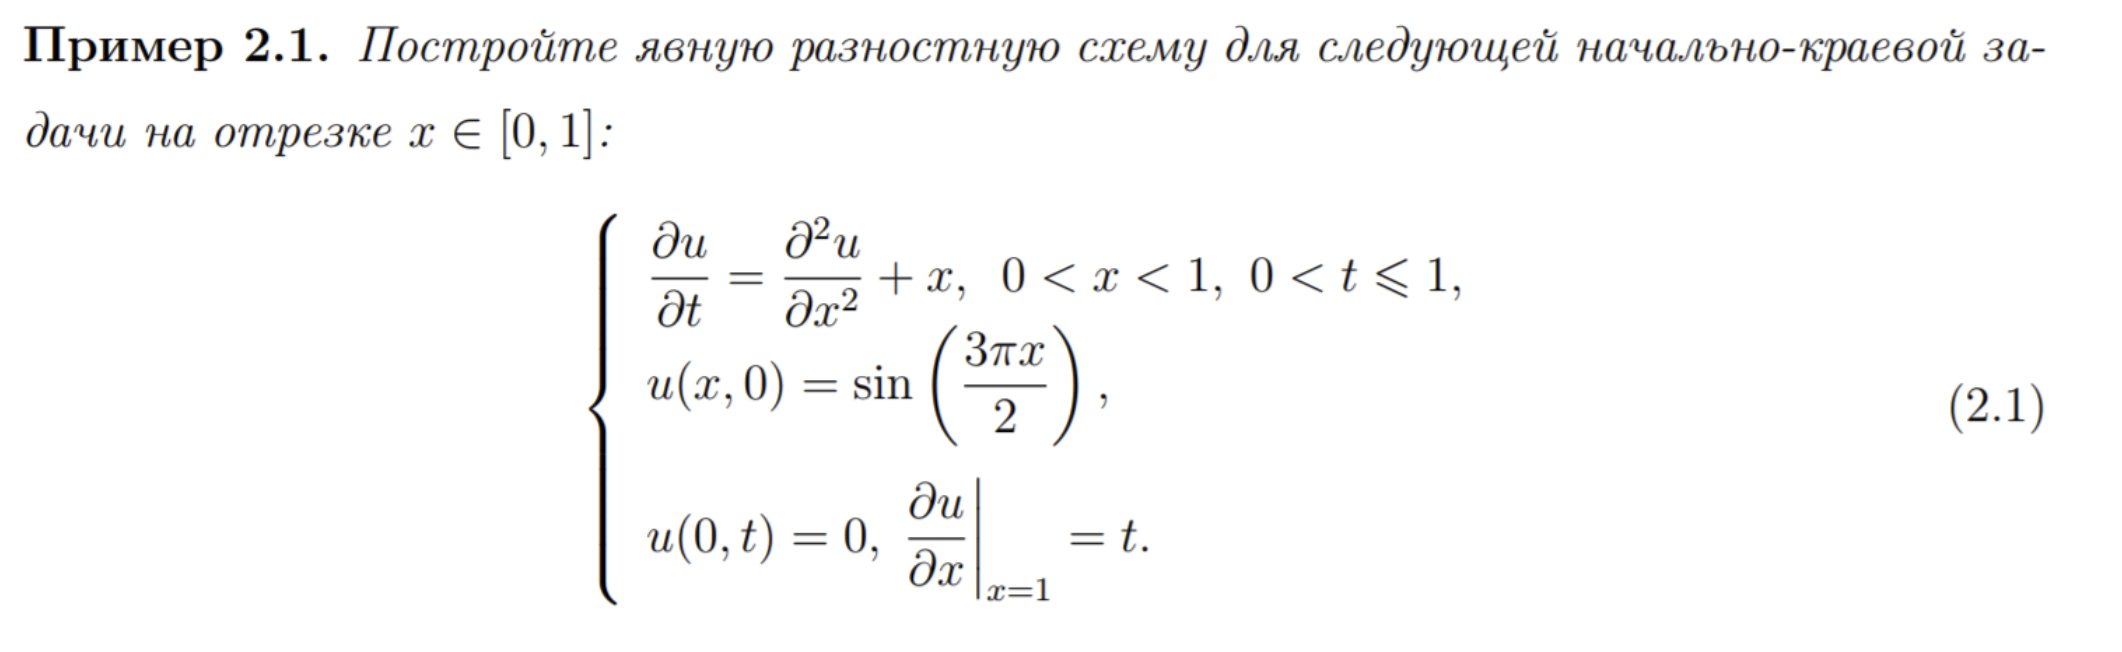

In [2]:
Image("test.png")

In [5]:
plotly.offline.init_notebook_mode()
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Оформление графиков plotly
layout = go.Layout(
    scene = dict(
    xaxis = dict(
        title='x',
        gridcolor="rgb(255, 255, 255)",
        zerolinecolor="rgb(255, 255, 255)",
        showbackground=True,
        backgroundcolor="rgb(200, 200, 230)"),
                        
    yaxis = dict(
        title='y',
        gridcolor="rgb(255, 255, 255)",
        zerolinecolor="rgb(255, 255, 255)",
        showbackground=True,
        backgroundcolor="rgb(230, 200,230)"),
                        
    zaxis = dict(
        title='u(x, t)',
        gridcolor="rgb(255, 255, 255)",
        zerolinecolor="rgb(255, 255, 255)",
        showbackground=True,
        backgroundcolor="rgb(230, 230,200)",),),
    width=800, height=600, 
    margin=dict(
        r=20, b=10,
        l=10, t=10),
    )

In [115]:
def TDMA(data, F):
    '''
    Метод прогонки.
        
    Параметры: 
        coeffs (numpy.array): Трехдианональная матрица коэффициентов уравнений.
        F (numpy.array): Массив правых частей уравнений.
    Вывод:
        (numpy.array): Массив искомых значений неизвестной.
    '''
        
    N = len(F)
    x = [0]*(N)
    A = []
    C = [data[0][0]]
    B = [data[0][1]]
    for i in range(1, N-1):
        A.append(data[i][i-1])
        C.append(data[i][i])
        B.append(data[i][i+1])
    A.append(data[-1][-2])
    C.append(data[-1][-1])

    alpha = [-B[0]/C[0]]*(N-1)
    beta = [F[0]/C[0]]*(N-1)

    for i in range(1, N-1):
        alpha[i] = -B[i]/(A[i-1]*alpha[i-1] + C[i])
        beta[i] = ((F[i] - A[i-1]*beta[i-1])/(A[i-1]*alpha[i-1] + C[i]))  
    x[-1] = (F[-1] - A[-1]*beta[-1]) / (C[-1] + A[-1]*alpha[-1])
    for i in reversed(range(N-1)):
        x[i] = alpha[i]*x[i+1] + beta[i]
    return(np.array(x))

In [137]:
class HeatEquationSolver_1:
    '''
    Класс для численного решения одномерного уравнения теплопроводности.
    '''
    
    def __init__(self,
                 X_START=0, X_END=2,
                 T_START=0, T_END=10,
                N=5, M=5):
        
        # Задание параметров сетки
        self.X_START = X_START
        self.X_END = X_END
        self.T_START = T_START
        self.T_END = T_END
        self.N = N
        self.M = M
        
        self.x = np.linspace(X_START, X_END, N)
        self.t = np.linspace(T_START, T_END, M)
        
        self.dx = self.x[1] - self.x[0]
        self.dt = self.t[1] - self.t[0]
    
    def initialize(self, a, f, fi, gamma1, gamma2, delta2, delta1, mu1, mu2):
        '''
        Задание коэффициентов и функций конкретной задачи.
        '''
        
        self.a = a
        self.f = f
        self.fi = fi
        self.gamma1 = gamma1
        self.gamma2 = gamma2
        self.delta1 = delta1
        self.delta2 = delta2
        self.mu1 = mu1
        self.mu2 = mu2
        
        self.u = np.zeros((self.M, self.N))
        self.v = np.zeros((self.M, self.N))
        
        self.u[0] = self.fi(self.x)
        
    def calculate_layer(self, m, step_x, step_t):
        '''
        Метод, вычисляющий значения u(x, t) на новом временном слое.
        
        Параметры:
            m (int): номер слоя для вычисления
            step_x (float): шаг по x
            step_t (float): шаг по t
        '''
        
        m = m
        data = np.zeros((self.N, self.N))
        data[0][0] = step_x*self.delta1 + self.gamma1
        data[0][1] = -self.gamma1
        
        data[-1][-2] = -self.gamma2
        data[-1][-1] = step_x*self.delta2 + self.gamma2
        
        
        for i in range(1, self.N - 1):
            data[i][i-1] = self.a**2*step_t/step_x**2
            data[i][i] = -(2*self.a**2*step_t/step_x**2 + 1)
            data[i][i+1] = self.a**2*step_t/step_x**2
        
        F = np.concatenate(([step_x*self.mu1(self.t[m])], 
                            (-self.f(self.x, self.t[m-1])*step_t-self.u[m-1])[1:-1],
                           [step_x*self.mu2(self.t[m])]))
        
        new_layer = TDMA(data, F)

        return new_layer
        
    def calculate_u(self):
        print('Calculating...')
        borders = [[], []]
        for i in range(1, self.M):
            clear_output(wait = True)
            print(f'Progress: {round(i/(self.M-1), 2)*100}%')
            new_layer = self.calculate_layer(i, step_x = self.dx, step_t = self.dt)
            self.u[i] = new_layer

    def calculate_v(self):
        print('Calculating...')
        for i in range(self.M):
            for j in range(self.N):
                self.v[j][i] = self.x[i] * self.t[j] + np.exp(-(3 * np.pi / 2)**2 * self.t[j]) * np.sin(3 * np.pi * self.x[i]/2)
    
    def plot_u(self, filename='OMM_Task_2_1', online=True):
        '''
        Метод, который строит 3D график численного решения.
        '''
        
        data = [go.Surface(x = self.x, y = self.t, z = self.u, colorscale = 'YlGnBu')]
        
        fig = go.Figure(data = data, layout = layout)  # Стиль графика определен в начале программы
        if not online:
            return plotly.offline.iplot(fig, filename = filename)  # построение графика оффлайн влечет за собой
                                        # большой вес ноутбука, но построение почти мгновенное
        if online:
            return py.iplot(fig, filename = filename)  # Построение графика онлайн - маленький вес ноутбука, 
                                        # сравнительно долгое построение

    def plot_v(self, filename='OMM_Task_2_1', online=True):
        '''
        Метод, который строит 3D график аналитического решения.
        '''
        
        data = [go.Surface(x = self.x, y = self.t, z = self.v, colorscale = 'YlGnBu')]
        
        fig = go.Figure(data = data, layout = layout)  # Стиль графика определен в начале программы
        if not online:
            return plotly.offline.iplot(fig, filename = filename)  # построение графика оффлайн влечет за собой
                                        # большой вес ноутбука, но построение почти мгновенное
        if online:
            return py.iplot(fig, filename = filename)  # Построение графика онлайн - маленький вес ноутбука, 
                                        # сравнительно долгое построение

    def plot_v_u(self, filename='OMM_Task_2_1', online=True):
        '''
        Метод, который строит 3D график аналитического решения.
        '''
        
        data = [go.Surface(x = self.x, y = self.t, z = self.v-self.u, colorscale = 'YlGnBu')]
        
        fig = go.Figure(data = data, layout = layout)  # Стиль графика определен в начале программы
        if not online:
            return plotly.offline.iplot(fig, filename = filename)  # построение графика оффлайн влечет за собой
                                        # большой вес ноутбука, но построение почти мгновенное
        if online:
            return py.iplot(fig, filename = filename)  # Построение графика онлайн - маленький вес ноутбука, 
                                        # сравнительно долгое построение

    def plot_conditions(self):
        '''
        Метод, который строит график начального условия.
        '''

        plt.title('Initial Condition')
        plt.xlabel('x')
        plt.ylabel('u')
        plt.plot(self.x, self.u[0][:])

In [138]:
a = 1
def f(x, t):
    return x
def fi(x):
    return np.sin(3*np.pi*x/2)
gamma1 = 0
gamma2 = 1
delta1 = 1
delta2 = 0
def mu1(t):
    return 0
def mu2(t):
    return t

In [139]:
solver = HeatEquationSolver_1(X_END = 1, T_END = 1, N = 100, M = 100)
solver.initialize(a, f, fi, gamma1, gamma2, delta2, delta1, mu1, mu2)

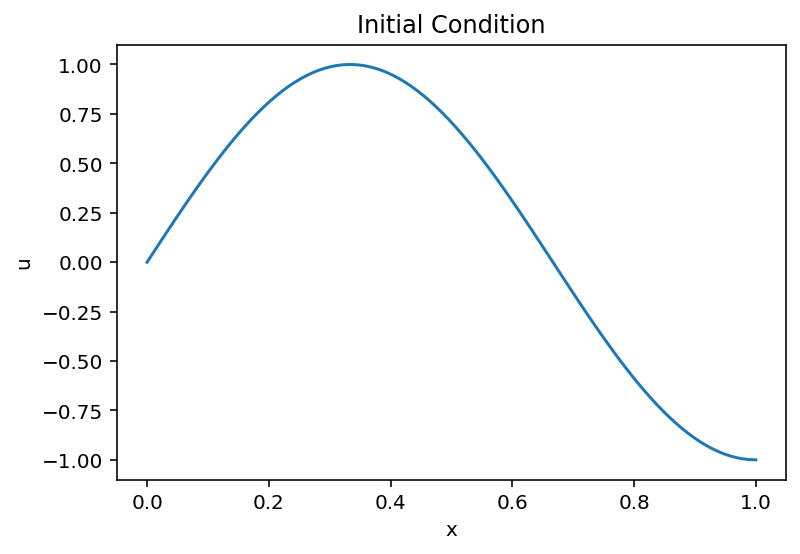

In [140]:
solver.plot_conditions()

In [141]:
borders = solver.calculate_u()
borders_ = solver.calculate_v()

Progress: 100.0%
Calculating...


In [142]:
solver.plot_u(online = False)

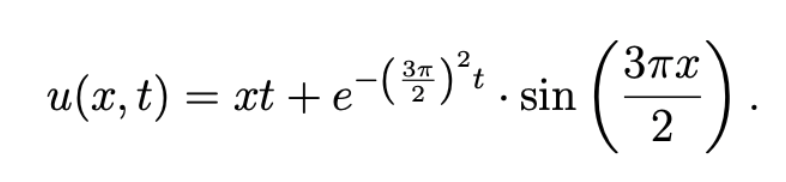

In [3]:
Image('analytical.png')

In [143]:
solver.plot_v(online = False)

In [144]:
solver.plot_v_u(online = False)

Progress: 100.0%
Calculating...


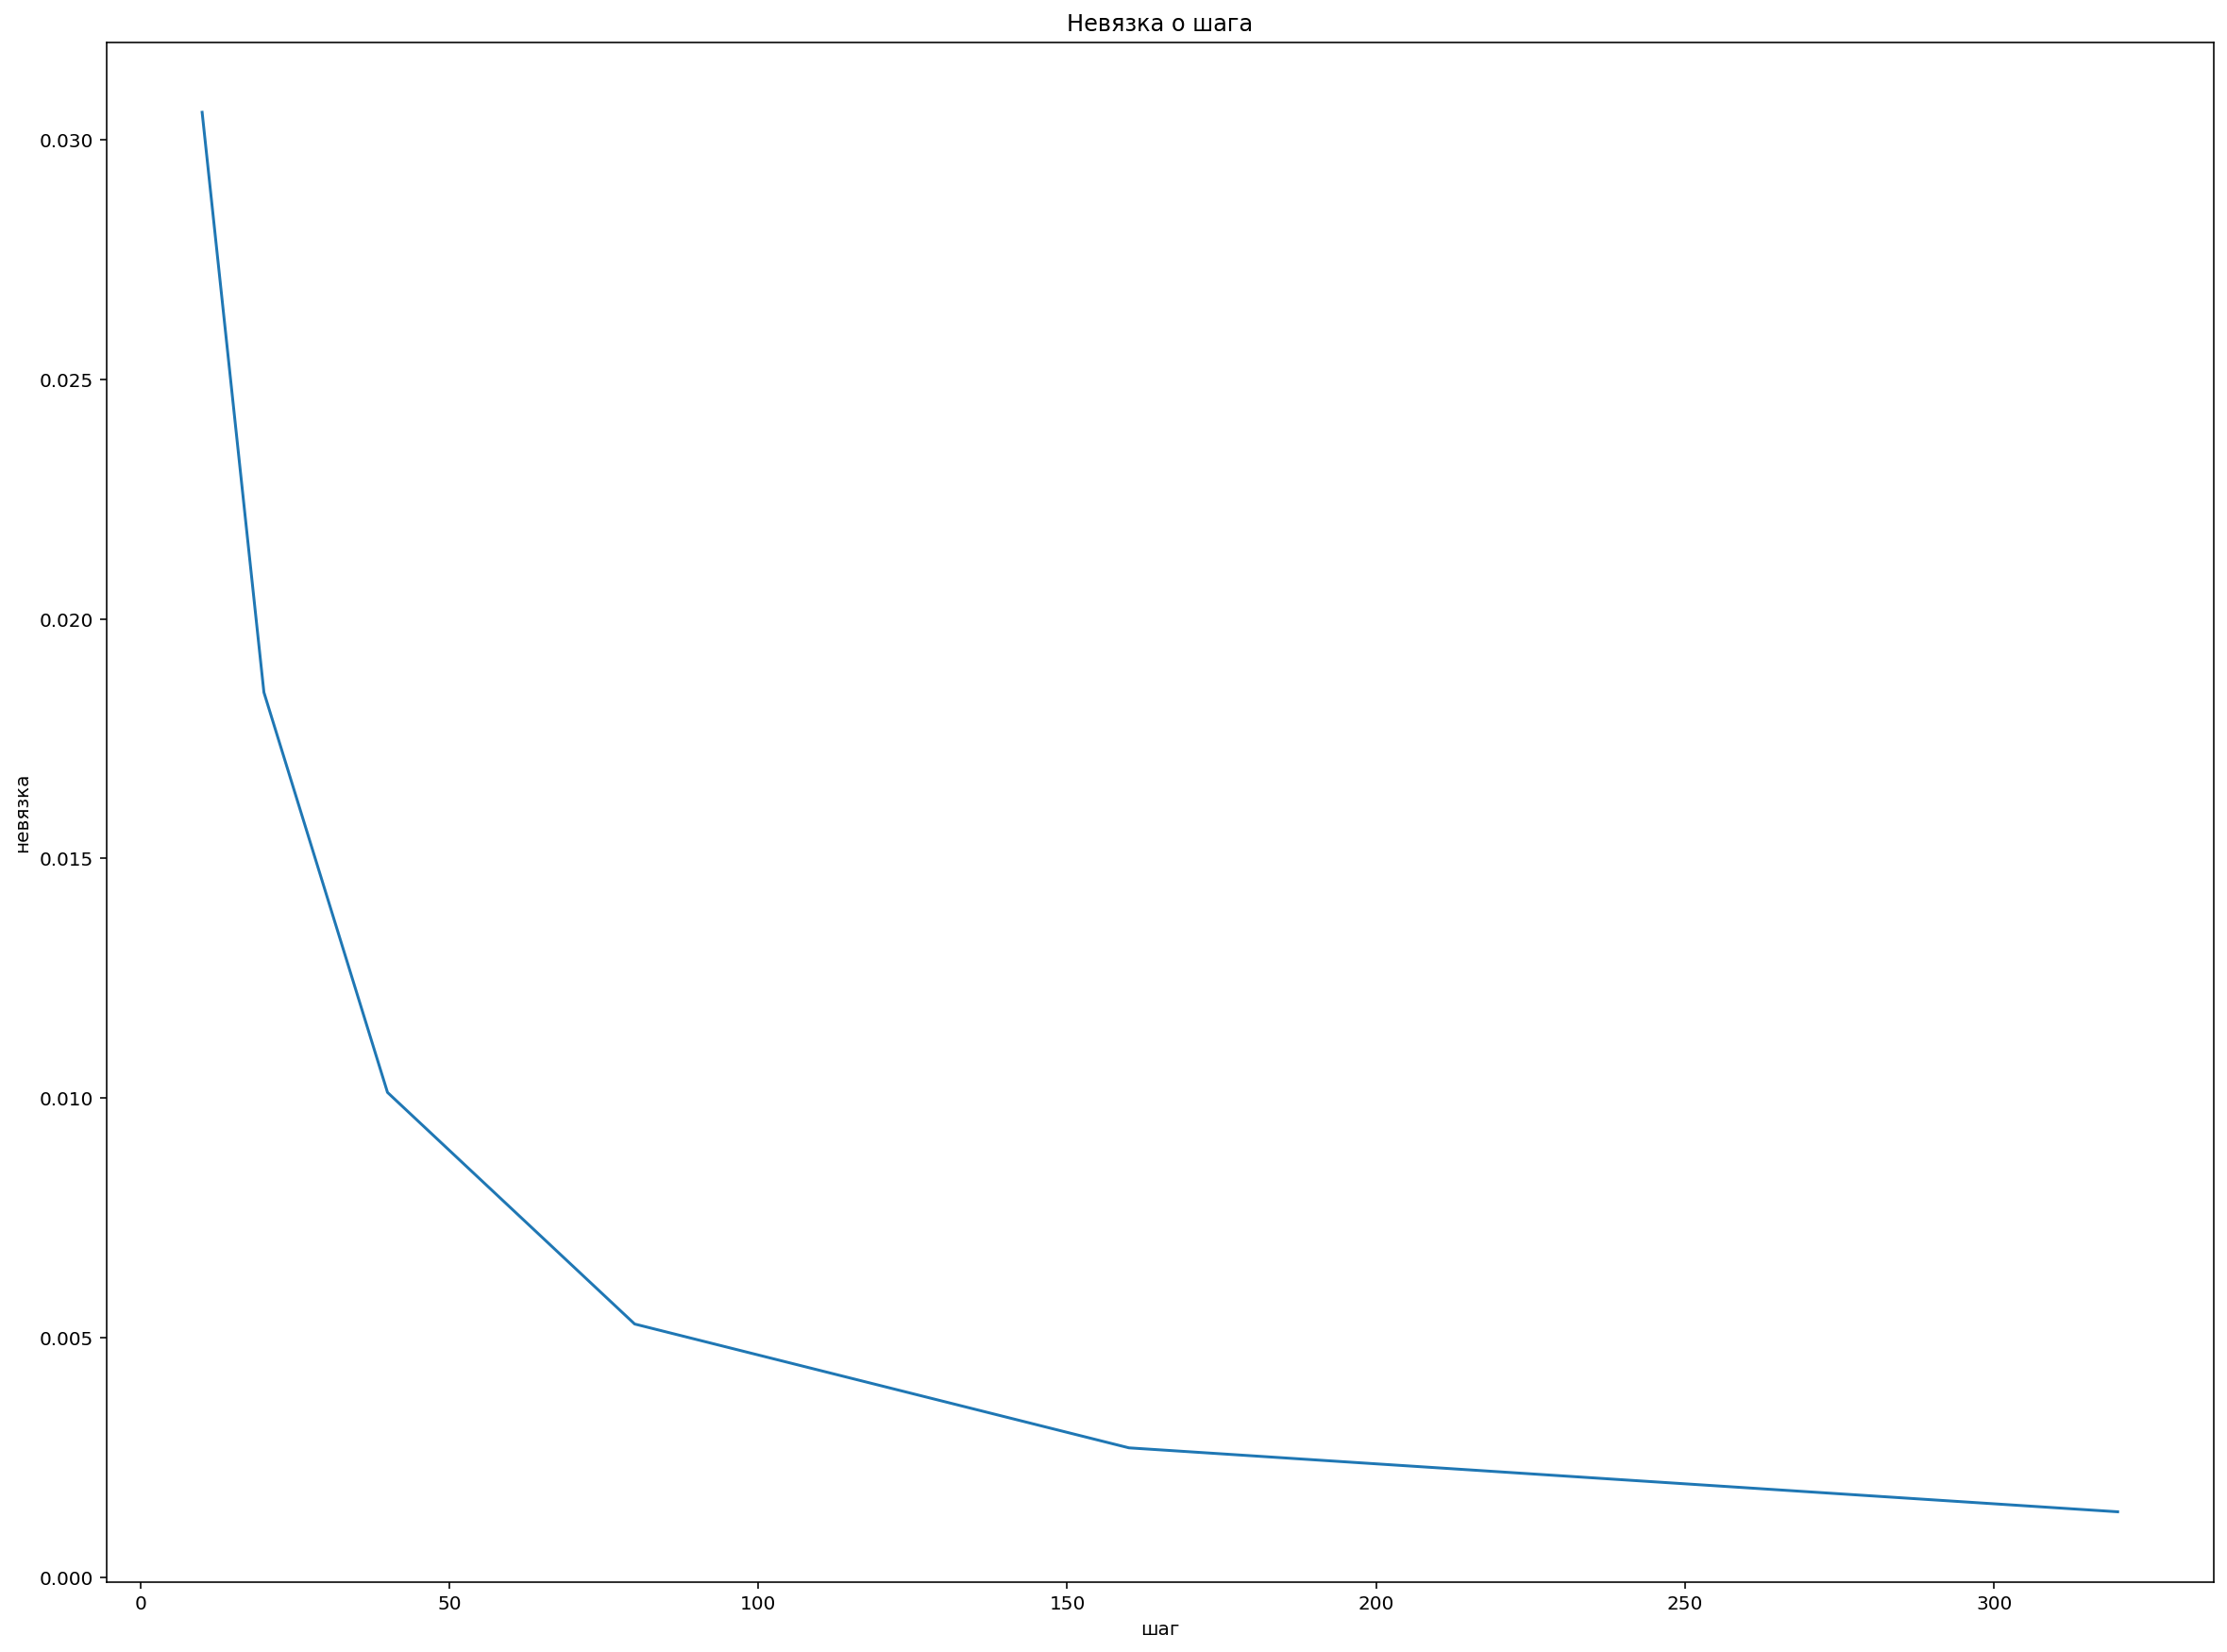

In [148]:
eps = []
for al in [10, 20, 40, 80, 160, 320]:
    solver = HeatEquationSolver_1(X_END = 1, T_END = 1, N = al, M = al)
    solver.initialize(a, f, fi, gamma1, gamma2, delta2, delta1, mu1, mu2)
    borders = solver.calculate_u()
    borders_ = solver.calculate_v()
    eps.append(np.abs(solver.u - solver.v).mean())

fig, ax = plt.subplots(figsize=(20, 15))
_ = ax.plot([10, 20, 40, 80, 160, 320], eps)
_ = ax.set(title='Невязка о шага', xlabel='шаг', ylabel='невязка')